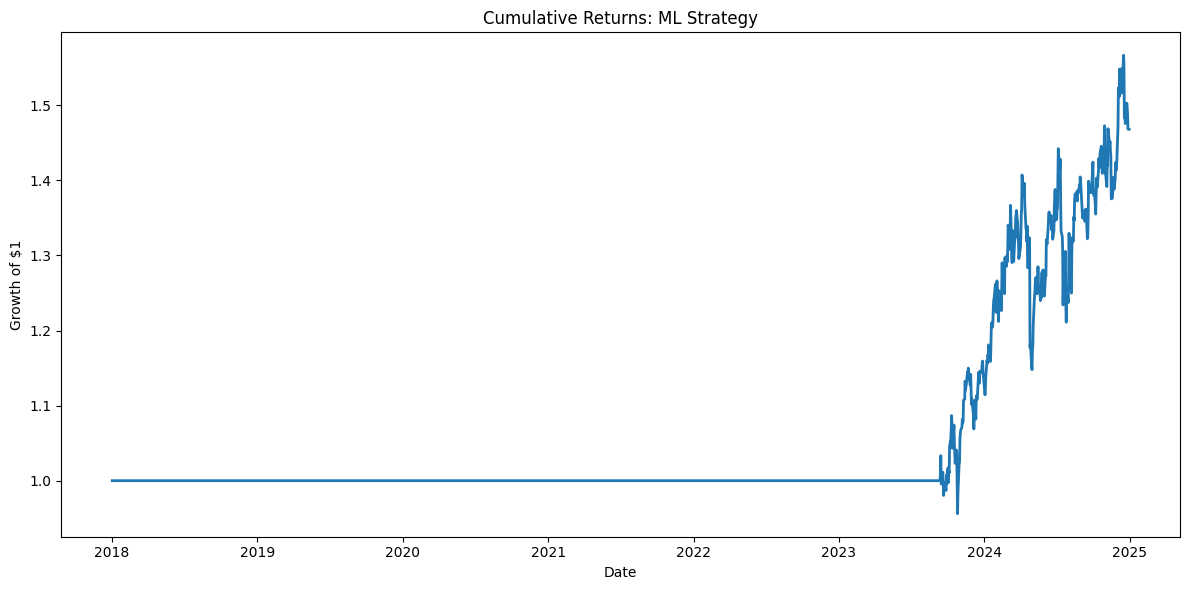

In [3]:
import sys, os
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV
import pandas as pd
import matplotlib.pyplot as plt

# Add the root directory (parent of notebooks/) to sys.path
project_root = os.path.abspath(os.path.join(os.getcwd(), "..")) #os.getcwd() returns current working directory, ".." goes one level up

if project_root not in sys.path:

    # Look for modules in project_root
    sys.path.insert(0, project_root)

from src.factors import calculate_zscore, calculate_momentum
from src.volatility_factors import calculate_realized_volatility, iv_realized_diff
from src.ml_pipeline import ml_dataset, train_and_predict_model
from src.portfolio import top_n_percent_signal, build_portfolio


# Load data
momentum   = pd.read_csv("../data/processed/momentum.csv", index_col = 0, parse_dates = True)
vrp        = pd.read_csv("../data/processed/volatility_risk_premium.csv", index_col = 0, parse_dates = True)
prices     = pd.read_csv("../data/processed/price_data.csv", index_col = 0, parse_dates = True)

# Calculate daily returns
returns = prices.pct_change().fillna(0)

# Load factor data
z_momentum = calculate_zscore(momentum)
z_vrp = calculate_zscore(vrp)

# Combine factors
factors = {"momentum": z_momentum, "vrp": z_vrp}

# Create dataset for ML training
ml_df = ml_dataset(factors, returns)

# Train and get predictions using RidgeCV
model = RidgeCV(alphas=[0.01, 0.1, 1.0, 10.0])
predicted_scores = train_and_predict_model(ml_df, model)

# Use predicted scores to build and backtest portfolio
signal = top_n_percent_signal(predicted_scores, pct = 0.2)
ml_strategy_returns = build_portfolio(returns, signal)

# Cumulative return (growth of $1)
c_ml = (1 + ml_strategy_returns).cumprod()

plt.figure(figsize = (12, 6))
plt.plot(c_ml, label = "ML Strategy", linewidth=2)
plt.title("Cumulative Returns: ML Strategy")
plt.xlabel("Date")
plt.ylabel("Growth of $1")

plt.tight_layout()
plt.show()

# Comments about the result - It seems that the ML based strategy actually underperforms compared to the simple factor signals.
# Possible causes I can think of are a lack of training samples, or perhaps the low cross-sectional area of stocks per date (5 in this case) limit the predictive power of ML models.